## Reinforcement Learning, Sutton and Barro

This notebook collects solutions for the exercises in the textbook

### Exercise 2.2

How does the softmax action selection using the Gibbs distribution fare on the 10-armed testbed?

In [121]:
import math
import random
import numpy as np
import pandas as pd
%matplotlib inline

In [122]:
class RandomVariable:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def get(self):
        return abs(random.gauss(self.mu,self.sigma))

In [123]:
class Estimate:
    """Estimate implements last seen estimate
    """
    def __init__(self):
        self.estimate = 0
        self.k = 0
        
    def __gt__(self, e):
        return self.estimate > e.estimate
        
    def update(self, value):
        self.estimate = value
        return self
        
    def get(self):
        return self.estimate

class OnlineAverage(Estimate):
    """OnlineAverage implements incremental mean 
    Q_(k+1) = Q_k + 1/(k+1)(r_(k+1) - Q_k)
    """      
    def update(self, value):
        Q_k = self.estimate
        Q_k = Q_k + 1/(self.k+1) * (value - Q_k)
        self.k = self.k + 1
        self.estimate=Q_k
        return self


In [124]:
# selection algorithms

# for the naive case, return v
def s_a(v, t):
    return v

# for the n bolzmann with temperature, return exp(v/t)
def s_bolzmann_a(v, t):
    return math.exp(v/t)
    
def s_d(f, I,t):
    s = 0
    for i in range(0,len(I)):
        s = s + f(I[i].estimate, t)
    return s

def softmax_action_probabilities(f, I,t):
    P = [0] * len(I)
    denominator = s_d(f, I,t)
    for i in range(0,len(I)):
        P[i] = f(I[i].estimate, t) / denominator
    return P

def softmax_selection(I,t):
    P = softmax_action_probabilities(s_bolzmann_a, I, 1.0)
    return np.random.choice(range(0,len(P)), 1, p=P)[0]

def greedy_selection(I,epsilon):
    if random.random() < epsilon:
        return random.randint(0,len(I) - 1)
    else:
        return I.index(max(I))

In [135]:
def simulate(selection, RV, I, num_trials, epsilon):
    rewards = []
    for i in range(0, num_trials):
        max_index = selection(I, 0.0)
        new_reward = RV[max_index].get()
        rewards.append((i,RV[max_index].mu,new_reward))
        I[max_index].update(new_reward)
    df = pd.DataFrame(rewards, columns=['iter','bandit_mean', 'reward'])
    df = df.set_index('iter')
    df['percent_optimal'] = (df['reward'] / max_reward) * 100.0
    return df

### Experiment Setup and Simulation

In [142]:


# 1. create N armed bandits and initialize with distributions
max_reward = 9
bandits = [(0,0.1),(1,0.1),(2,0.1),(3,0.1),(4,0.1),(5,0.1),(6,0.1),(7,0.1),(8,0.1),(9,0.1)]
RV = [RandomVariable(x[0],x[1]) for x in bandits]

# 2. setup experiment
num_trials = 10000

# 3. set initial estimates
initial_value = 100
I = [OnlineAverage().update(initial_value) for i in range(0,len(bandits))]

# 4. greedy method will explore alternative path with P = e
epsilon = 0.0

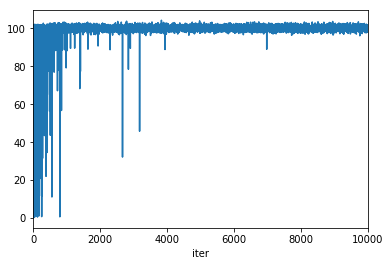

In [143]:
df_greedy = simulate(greedy_selection, RV, I, num_trials, epsilon)
df_greedy['percent_optimal'].plot()

## Testing

In [117]:
# testing Estimate
t_1 = [1,2,3,4,5]
e = Estimate()
for i in t_1:
    e.update(i)
assert(e.get() == 3.0)

t_1 = [0,0,0,0,0]
e = Estimate()
for i in t_1:
    e.update(i)
assert(e.get() == 0.0)

t_1 = [1,1,1,1,1]
e = Estimate()
for i in t_1:
    e.update(i)
assert(e.get() == 1.0)

t_1 = [2,3,4,5]
e = Estimate()
e.get()
e.update(2)
e.get()

2.0